In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from datetime import timedelta

# visualization
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

%matplotlib inline

# configure visualizations
sns.set_style('whitegrid')
figsize=(8,6)

In [2]:
def load_df(path, columns=None, use_threads=True):
    try:
        return pq.read_table(path, columns=columns, use_threads=use_threads).to_pandas()
    except Exception as e:
        print(e)

def downcast_ints(df):
    # downcast int types
    df_int = df.select_dtypes(include=['int'])
    converted_int = df_int.apply(pd.to_numeric, downcast='unsigned')
    df[converted_int.columns] = converted_int
    
    return df
        
def prepare(path,cols):

    df = load_df(path,cols)
    df = df.reset_index(drop=True)
    df = downcast_ints(df)
    
    return df

In [3]:
def boxPlotPPMTopBot(dfOG,dfGB,val,var,yaxis,xaxis,maxTopTop,maxTopBot):

    #get the top/bot 5 for our top/bot ppm
    dfTop5 = dfGB.drop(['average_ppm','std','count'], axis=1).head(5)
    dfBot5 = dfGB.drop(['average_ppm','std','count'], axis=1).tail(5)
    
    #inner join with original values to get the filtered list
    dfJoinTop = pd.merge(dfOG, dfTop5, left_on=var, right_on=var, how='inner')
    dfJoinBot = pd.merge(dfOG, dfBot5, left_on=var, right_on=var, how='inner')
    
    fig, axes = plt.subplots(1,2,constrained_layout=True,figsize=(15,8))

    #plot for top5
    bplotTop=sns.violinplot(y=val, x=var, data=dfJoinTop, width=1, palette="colorblind", cut = 0, ax=axes[0])
    #bplotTop=sns.stripplot(y=val, x=var, data=dfJoinTop, jitter=True, marker='o', alpha=0.5, color='black', ax=axes[0])
    bplotTop.set_xlabel("highest 5 "+xaxis,fontsize=15)
    bplotTop.set_xticklabels(bplotTop.get_xticklabels(),rotation=60)
    bplotTop.set_ylabel(yaxis,fontsize=15)
    bplotTop.tick_params(labelsize=14)
    axes[0].set_ylim(0, maxTopTop)
    
    
    #plot for bot5
    bplotBot=sns.violinplot(y=val, x=var, data=dfJoinBot, width=1, palette="colorblind", cut=0, ax=axes[1])
    #bplotBot=sns.stripplot(y=val, x=var, data=dfJoinBot, jitter=True, marker='o', alpha=0.5, color='black', ax=axes[1])
    bplotBot.set_xlabel("lowest 5 "+xaxis,fontsize=15)
    bplotBot.set_xticklabels(bplotBot.get_xticklabels(),rotation=60)
    bplotBot.set_ylabel(yaxis,fontsize=15)
    bplotBot.tick_params(labelsize=14)
    axes[1].set_ylim(0, maxTopBot)
    
    plt.show()
    
def boxPlotPPMAll(df,val,var,yaxis,xaxis,maxTop):
    
    fig, ax = plt.subplots(1,figsize=(7,8))
    #plt.figure(figsize=(7,8))
    bplotTop=sns.violinplot(y=val, x=var, data=df, width=1, palette="colorblind", cut=0, ax=ax)
    #bplotTop=sns.stripplot(y=val, x=var, data=df, jitter=True, marker='o', alpha=0.5, color='black')
    bplotTop.set_xlabel(xaxis,fontsize=15)
    bplotTop.set_xticklabels(bplotTop.get_xticklabels(),rotation=60)
    bplotTop.set_ylabel(yaxis,fontsize=15)
    bplotTop.tick_params(labelsize=14)
    ax.set_ylim(0, maxTop)
    
    bplotTop.figure
    

In [4]:
cols1 = ['id','sample_id','charger','health']
dfBatteryDetails = prepare('2-datasets/battery_details.parquet',cols1)

#cols2 = ['id','device_id', 'timestamp', 'battery_level', 'network_status', 'screen_brightness', 'screen_on', 'timezone', 'country_code', 'period', 'size', 'direction', 'ppm']
cols2 = ['id','timestamp', 'battery_level','period', 'direction', 'ppm']
dfSamples = prepare('2-datasets/samplesPPM.parquet',cols2)

In [5]:
df_inner = pd.merge(dfSamples, dfBatteryDetails, left_on='id', right_on='sample_id', how='inner')

In [6]:
df_inner_droppedDup = df_inner.drop(['id','sample_id', 'timestamp', 'battery_level'], axis=1).drop_duplicates()

In [7]:
def batteryDetailsGroupBy(dataframe, var, direction):
    df = dataframe.groupby([var,'direction'])['ppm'].agg(average_ppm='mean', std='std', count='count').reset_index().sort_values(['average_ppm'], ascending=False)
    return df.loc[(df['direction'] == direction)]

dfChargerGBPos = batteryDetailsGroupBy(df_inner_droppedDup,'charger',1)
dfChargerGBNeg = batteryDetailsGroupBy(df_inner_droppedDup,'charger',-1)

dfHealthGBPos = batteryDetailsGroupBy(df_inner_droppedDup,'health',1)
dfHealthGBNeg = batteryDetailsGroupBy(df_inner_droppedDup,'health',-1)

     charger  direction  average_ppm       std   count
1         AC        1.0     0.642176  0.385962  254009
3  UNPLUGGED        1.0     0.529482  0.348949   32457
5        USB        1.0     0.480589  0.416506   23328
     charger  direction  average_ppm       std   count
4        USB       -1.0     0.450146  0.500357    7651
0         AC       -1.0     0.417604  0.458973   38927
2  UNPLUGGED       -1.0     0.344176  0.399651  278382


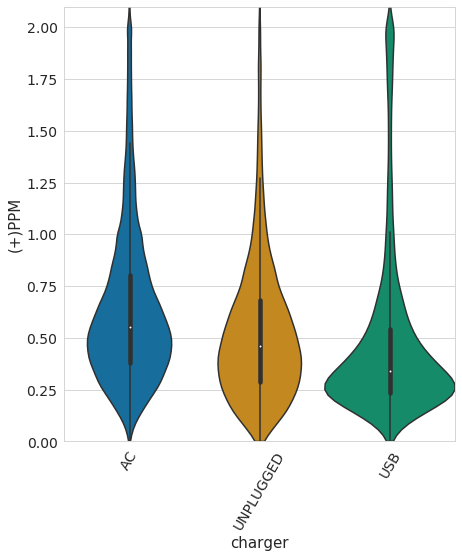

In [ ]:
print(dfChargerGBPos);
boxPlotPPMAll(df_inner_droppedDup.loc[(df_inner_droppedDup['direction'] == 1)],'ppm','charger','(+)PPM','charger',2.1);
print(dfChargerGBNeg);
boxPlotPPMAll(df_inner_droppedDup.loc[(df_inner_droppedDup['direction'] == -1)],'ppm','charger','(-)PPM','charger',2.1);


In [ ]:
print(dfHealthGBPos);
boxPlotPPMAll(df_inner_droppedDup.loc[(df_inner_droppedDup['direction'] == 1)],'ppm','health','(+)PPM','health',2.1);
print(dfHealthGBNeg);
boxPlotPPMAll(df_inner_droppedDup.loc[(df_inner_droppedDup['direction'] == -1)],'ppm','health','(-)PPM','health',2.5);